<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-half-adder-gate" data-toc-modified-id="Define-half-adder-gate-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define half-adder gate</a></span></li><li><span><a href="#Train-network" data-toc-modified-id="Train-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train network</a></span></li><li><span><a href="#Analyse-results" data-toc-modified-id="Analyse-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyse results</a></span><ul class="toc-item"><li><span><a href="#Plot-final-matrix" data-toc-modified-id="Plot-final-matrix-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plot final matrix</a></span></li><li><span><a href="#Plot-parameters" data-toc-modified-id="Plot-parameters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plot parameters</a></span></li></ul></li></ul></div>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import glob
from IPython.display import display
from IPython.core.debugger import set_trace
from collections import OrderedDict
import itertools
import os
import sys
import pickle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sympy
import pandas as pd

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import cufflinks

import qutip
import theano
import theano.tensor as T

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import qubit_network.net_analysis_tools as nat
import qubit_network.utils
from qubit_network.utils import chop, complex2bigreal, bigreal2complex, bigreal2qobj
from qubit_network.QubitNetwork import pauli_product
from qubit_network.model import QubitNetworkGateModel
from qubit_network.Optimizer import Optimizer
from qubit_network.net_analysis_tools import NetDataFile, NetsDataFolder

# Define half-adder gate
The half-adder gate is a toffoli gate, followed by a CNOT gate between first and third qubit.

The first two input qubits are the inputs to be summed, the second output qubit is the (half) sum, the third output qubit the carrier, and the first output qubit is ancillary.

<IPython.core.display.Javascript object>


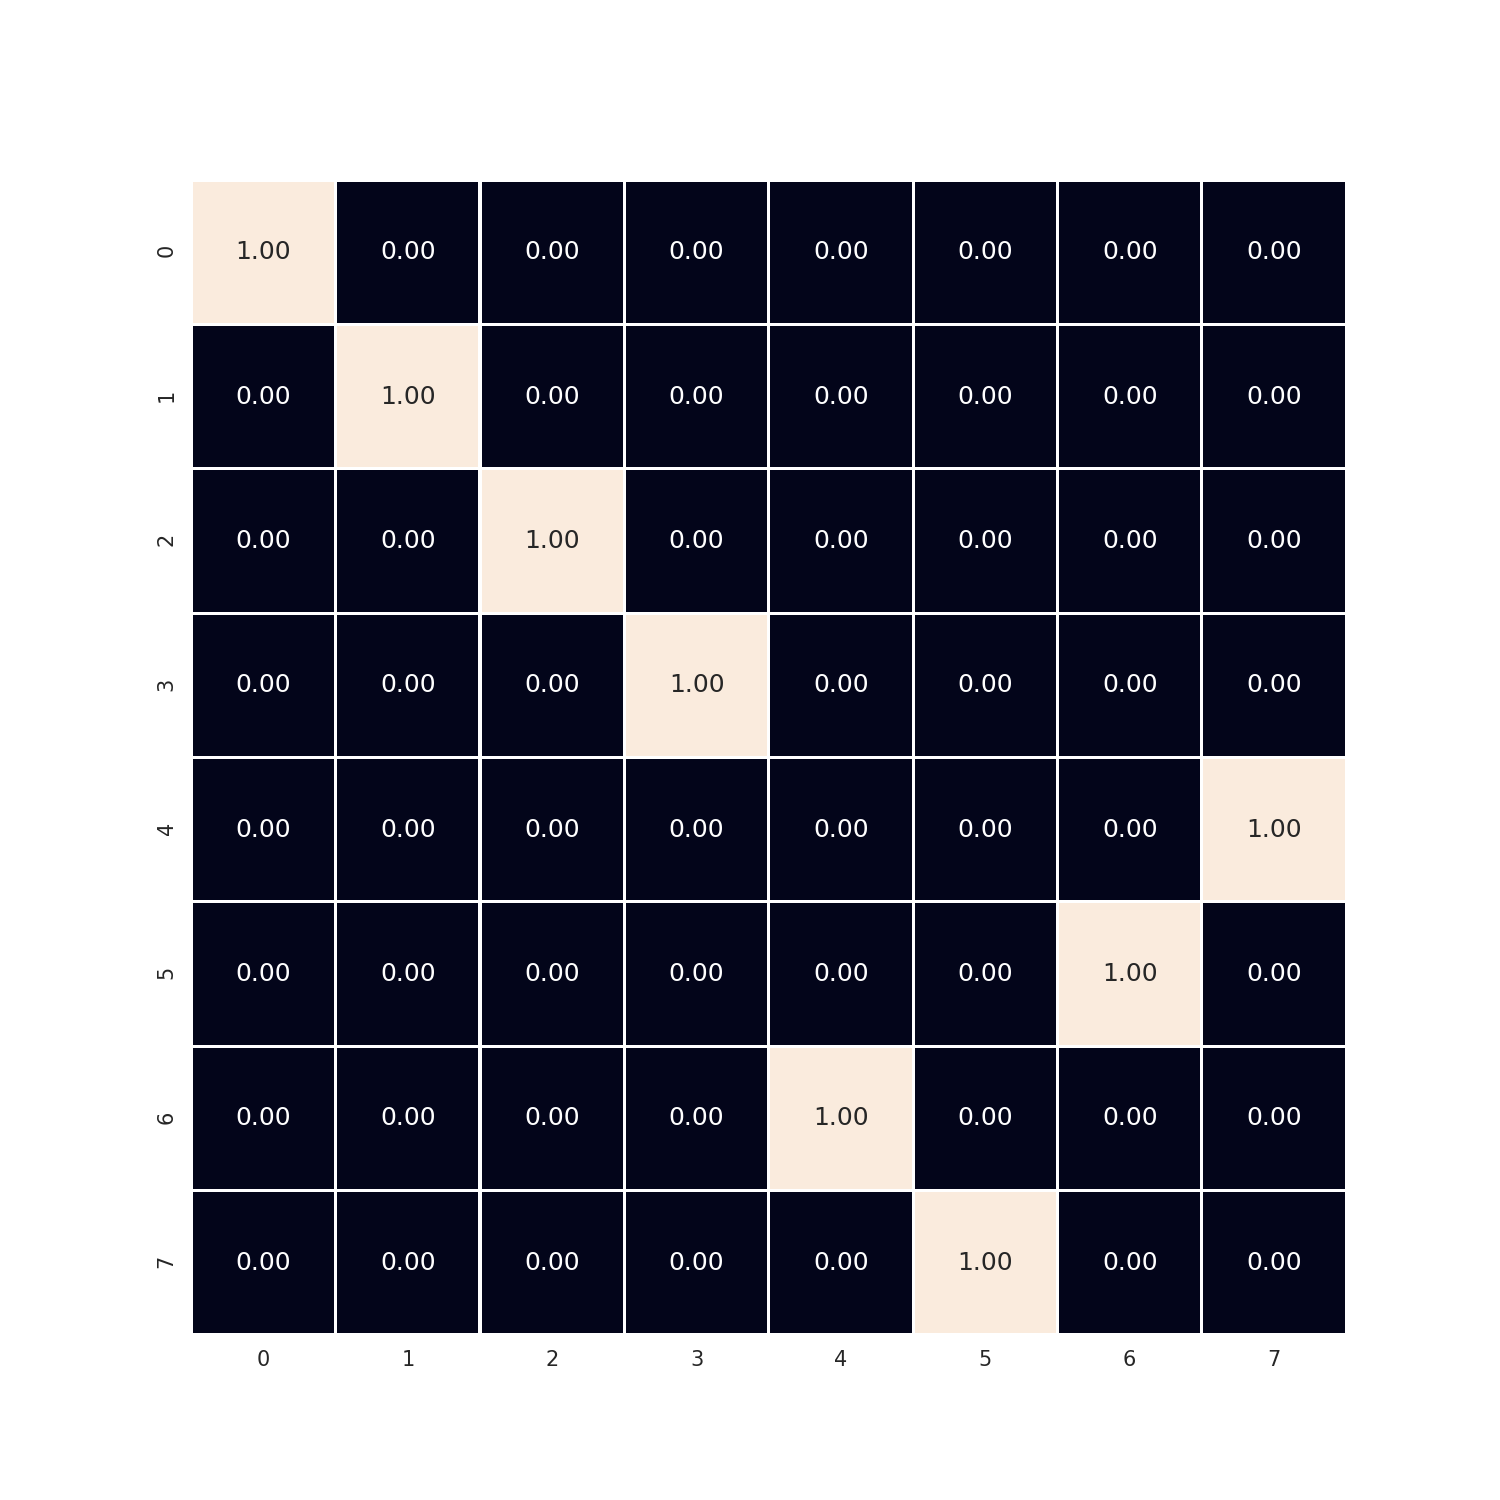

In [3]:
halfadder = (qutip.cnot(3, 0, 1) * qutip.toffoli())

nat.plot_gate(halfadder)

# Train network

Compiling model ... done.


<IPython.core.display.Javascript object>


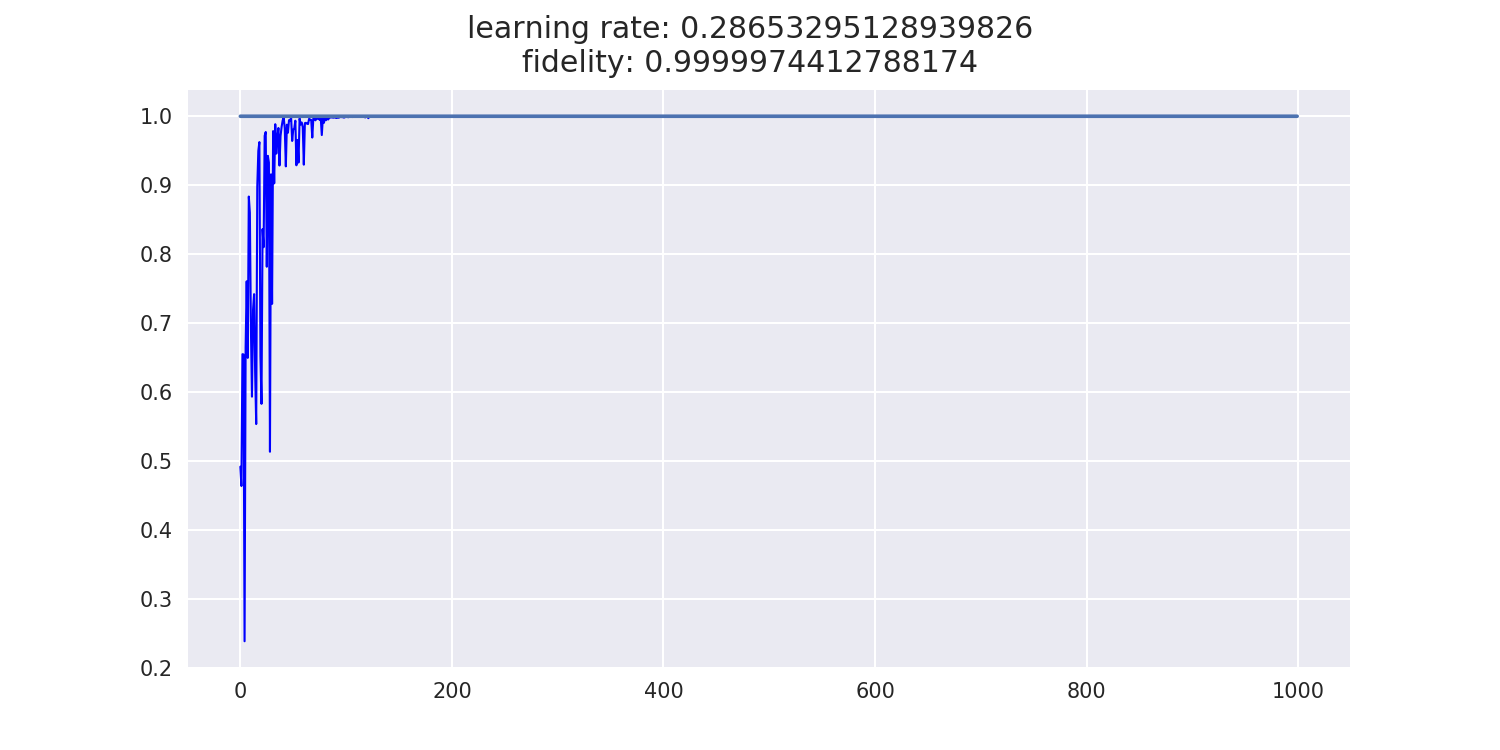

In [22]:
net = QubitNetworkGateModel(
    num_qubits=4,
    num_system_qubits=3,
    interactions='all',
    initial_values=2
)
optimizer = Optimizer(
    net=net,
    learning_rate=1.,
    decay_rate=.005,
    n_epochs=500,
    batch_size=2,
    target_gate=halfadder,
    training_dataset_size=200,
    test_dataset_size=100,
    sgd_method='momentum'
)
optimizer.run()

In [29]:
fids = net.fidelity_test(1000, return_mean=False)

In [27]:
optimizer.save_results('../data/new_nets/halfadder_3q+1a_all_f999999.pickle')

Successfully saved to ../data/new_nets/halfadder_3q+1a_all_f999999.pickle


# Analyse results

In [37]:
NetsDataFolder('../data/new_nets/').filter('half*')[0].fidelity_test(1000)

## Plot final matrix

<IPython.core.display.Javascript object>


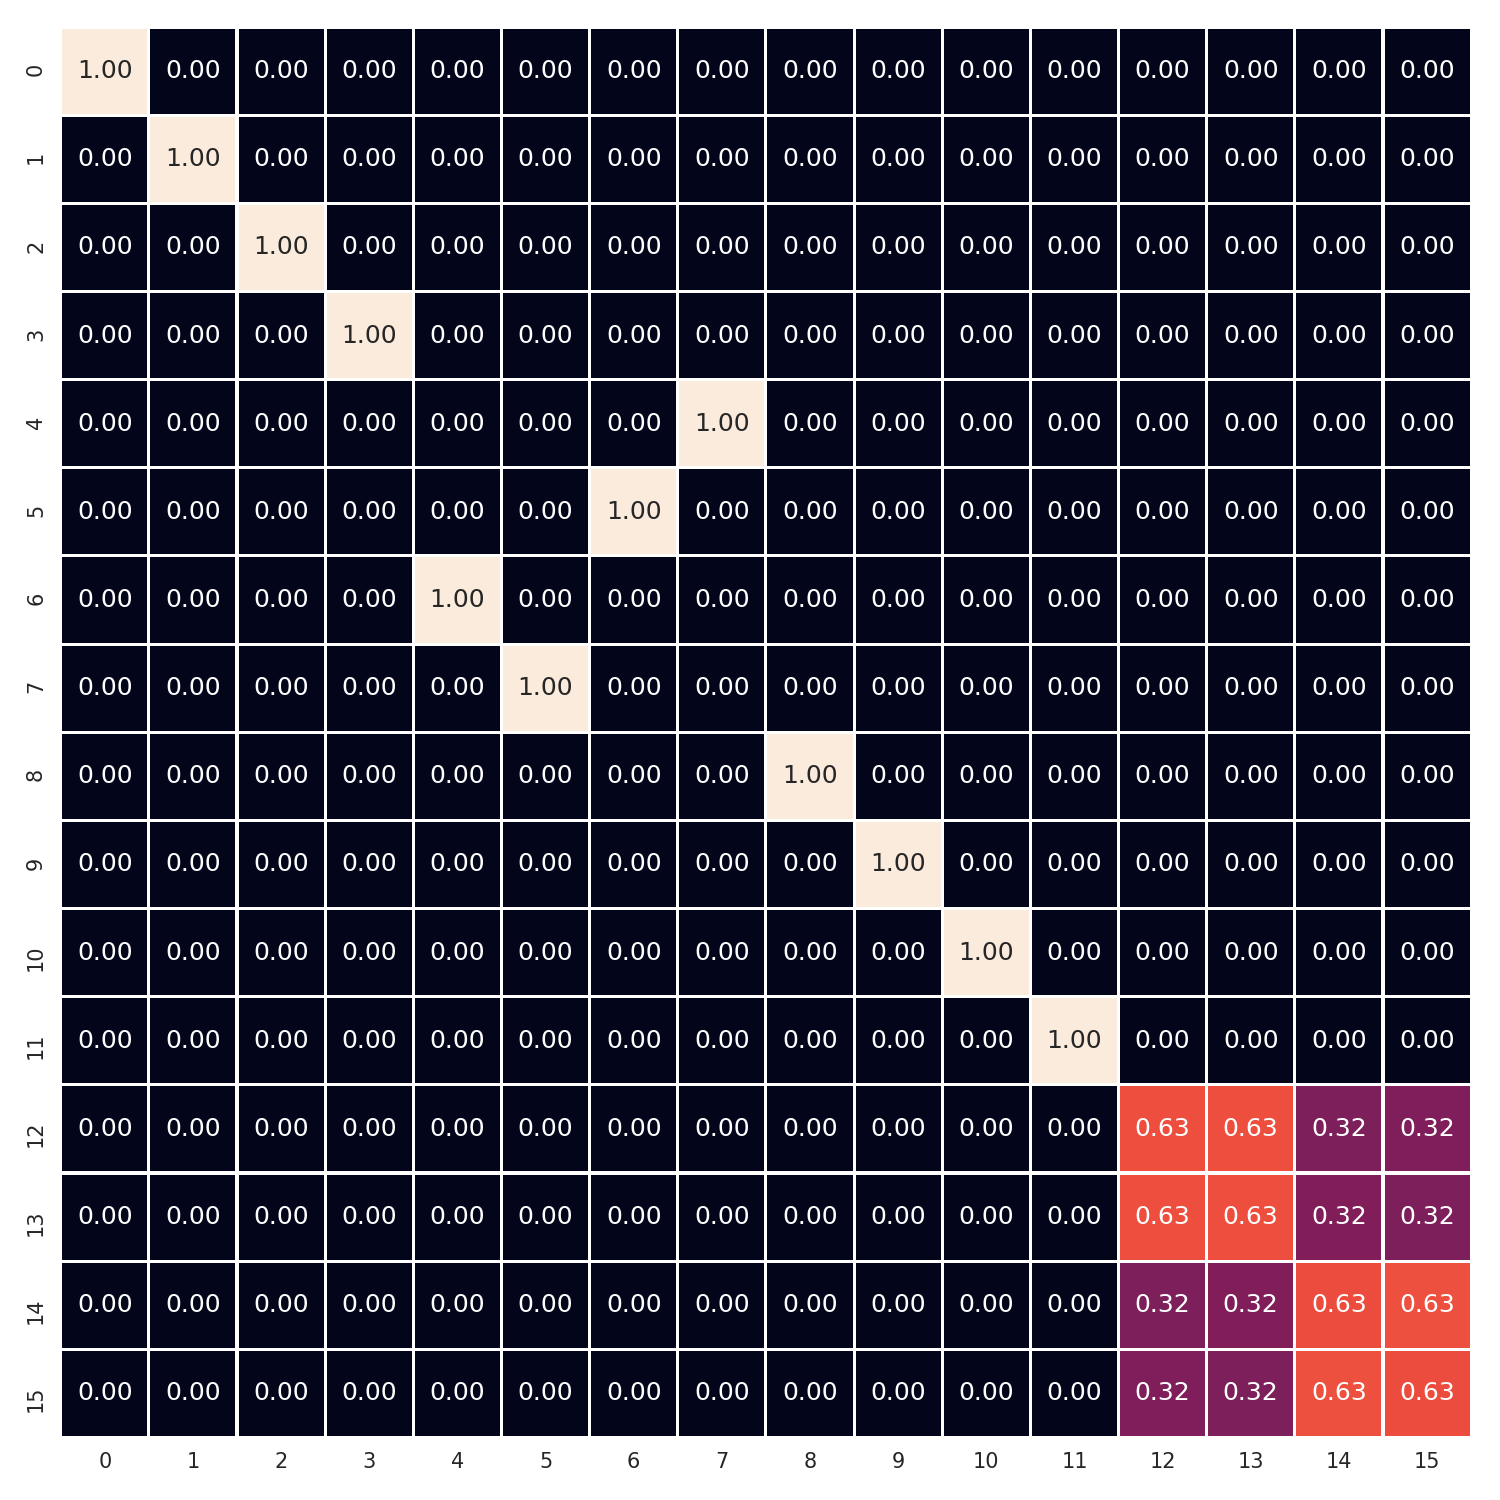

In [57]:
ha_datafile = NetsDataFolder('../data/new_nets/').filter('halfadder_3q+1a_all_f999999')[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nat.plot_gate(ha_datafile, permutation=[3, 0, 1, 2], ax=ax)
plt.tight_layout()

In [58]:
fig.savefig('halfadder_finalmatrix.pdf')

## Plot parameters

In [54]:
NetsDataFolder('../data/new_nets/').filter('halfadder_3q+1a_all_f999999').plot_parameters()

<IPython.core.display.Javascript object>


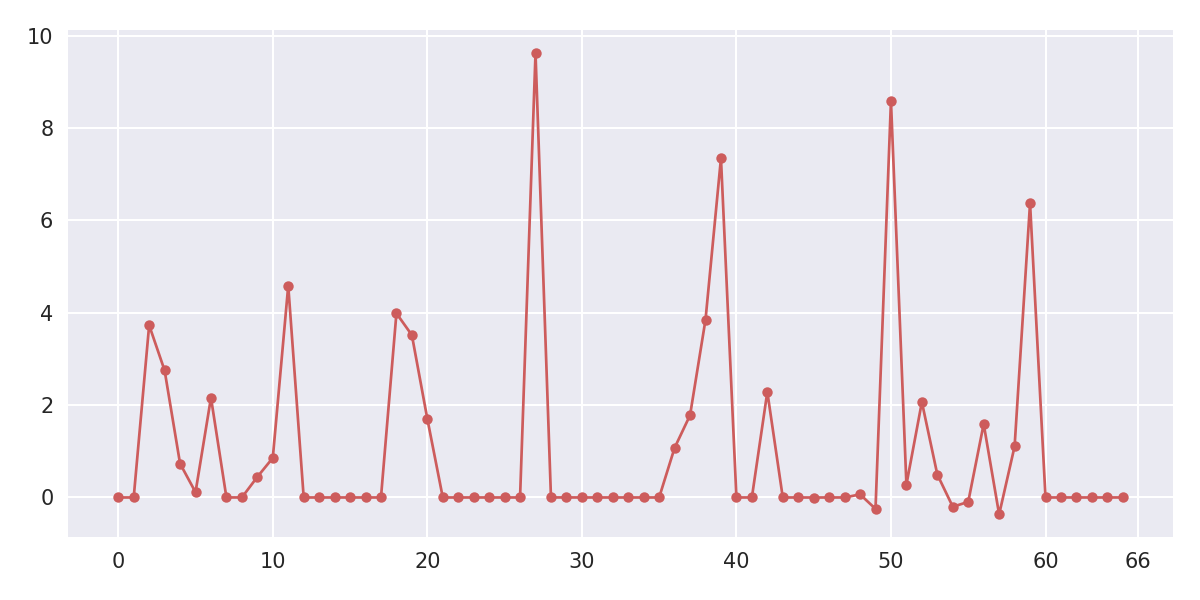

In [56]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

data = NetsDataFolder('../data/new_nets/').filter('halfadder_3q+1a_all_f999999').view_parameters().values[:, 0]
# df.T.reset_index(drop=True).plot(ax=ax, marker='o', markersize=4., legend=False)
ax.plot(np.arange(data.shape[0]), data, 'o-', color='indianred', markersize=5, linewidth=1.3)

# ax.set_title('Different solutions for Toffoli with diagonal interactions', fontsize=16)
# ax.set_xlabel('Parameters', fontsize=14)
# ax.set_xlabel('')
# ax.set_ylabel('Values', fontsize=14)

# better range
# ax.set_xlim(-0.1 , 8.1)
# mathify xaxis labels
ax.set_xticks(np.concatenate([np.arange(0, data.shape[0], 10), [66]]))
# fix sizes
plt.tight_layout()
# save to file
fig.savefig('halfadder_all.pdf', bbox_inches='tight')

In [188]:
# import pandas
vanishing_interactions = vanishing_elements(net)
# vanishing_interactions = [list(elem) for elem in vanishing_interactions]
# pandas.DataFrame([str(item) for item in vanishing_interactions])
pandas.DataFrame(transpose(vanishing_interactions))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3,3,"(0, 3)","(0, 3)","(0, 3)","(0, 3)","(0, 3)","(0, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(2, 3)","(2, 3)","(2, 3)","(2, 3)","(2, 3)","(2, 3)"
1,x,y,xx,xy,yx,yy,zx,zy,xx,xy,yx,yy,zx,zy,xx,xy,yx,yy,zx,zy
